# AI502/KSE527, Homework 02

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.models as models

from torchsummary import summary
from tqdm.auto import tqdm

from ptflops import get_model_complexity_info 
## Reference of ptflops: https://github.com/sovrasov/flops-counter.pytorch

# CIFAR100

In [25]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 128
NUM_EPOCH = 100
LEARNING_RATE = 0.01
CRITERION = nn.CrossEntropyLoss()

In [26]:
# CIFAR10 Dataset
train_dataset = dsets.CIFAR100(root='./data', train=True, 
                              transform=transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]), download=True)
test_dataset = dsets.CIFAR100(root='./data', train=False,
                             transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                        ]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


# Fit / Eval function

In [4]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [5]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(image)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
    pred_labels = pred_labels.argmax(axis=1)
    acc = sum(real_labels==pred_labels)/len(real_labels)*100
    
    return acc

### Model

In [29]:
plainnet_model = Net18(PlainBlock, [2, 2, 2, 2], 100).cuda()

In [30]:
pm_losses = []
pm_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    pm_loss = fit(plainnet_model, train_loader)
    pm_losses.append(pm_loss)
    pm_acc = eval(plainnet_model, test_loader)
    pm_accuracy.append(pm_acc)
    
    if (epoch + 1) % 10 == 0:
        print("{} epoch - loss : {}, accuracy : {}".format(epoch + 1, pm_loss, pm_acc))

10 epoch - loss : 1.3271433508304684, accuracy : 53.580000000000005
20 epoch - loss : 0.677365638258512, accuracy : 64.12
30 epoch - loss : 0.33553175811115127, accuracy : 66.55
40 epoch - loss : 0.16156362107647654, accuracy : 67.08
50 epoch - loss : 0.08409200240965084, accuracy : 68.15
60 epoch - loss : 0.05035607823554207, accuracy : 68.94
70 epoch - loss : 0.036974574856059934, accuracy : 69.47
80 epoch - loss : 0.02523660328706055, accuracy : 69.75
90 epoch - loss : 0.015616330201439845, accuracy : 70.75
100 epoch - loss : 0.014338540823182182, accuracy : 70.72



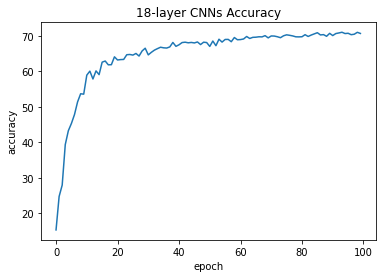

In [31]:
import matplotlib.pyplot as plt
plt.plot(pm_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('18-layer CNNs Accuracy')
plt.show()

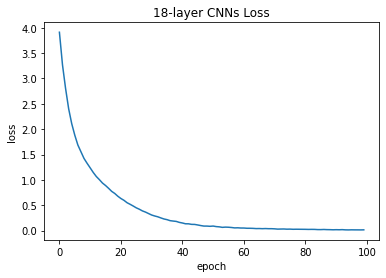

In [32]:
import matplotlib.pyplot as plt
plt.plot(pm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('18-layer CNNs Loss')
plt.show()

In [19]:
resnet_model = Net18(ResidualBlock, [2, 2, 2, 2], 100).cuda()

In [16]:
rm_losses = []
rm_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    rm_loss = fit(resnet_model, train_loader)
    rm_losses.append(rm_loss)
    rm_acc = eval(resnet_model, test_loader)
    rm_accuracy.append(rm_acc)
    
    if (epoch + 1) % 10 == 0:
        print("{} epoch - loss : {}, accuracy : {}".format(epoch + 1, rm_loss, rm_acc))

10 epoch - loss : 1.15156332214775, accuracy : 59.17
20 epoch - loss : 0.5622904802984594, accuracy : 65.62
30 epoch - loss : 0.23905683632778085, accuracy : 66.92
40 epoch - loss : 0.10896841621459902, accuracy : 68.93
50 epoch - loss : 0.048784743089352725, accuracy : 70.42
60 epoch - loss : 0.03340044162233772, accuracy : 70.53
70 epoch - loss : 0.018388831616400758, accuracy : 71.56
80 epoch - loss : 0.010983436525611163, accuracy : 71.83
90 epoch - loss : 0.007414708246269723, accuracy : 72.41
100 epoch - loss : 0.005196140165609853, accuracy : 72.64



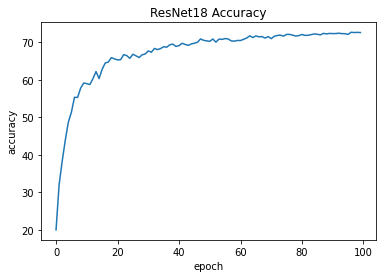

In [17]:
import matplotlib.pyplot as plt
plt.plot(rm_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ResNet18 Accuracy')
plt.show()

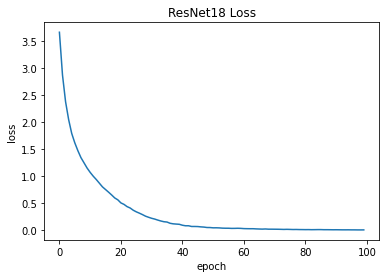

In [18]:
import matplotlib.pyplot as plt
plt.plot(rm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ResNet18 Loss')
plt.show()

In [20]:
mobilenet_model = Net18(MobileBlock, [2, 2, 2, 2], 100).cuda()

In [21]:
mm_losses = []
mm_accuracy = []
for epoch in tqdm(range(NUM_EPOCH)):
    mm_loss = fit(mobilenet_model, train_loader)
    mm_losses.append(mm_loss)
    mm_acc = eval(mobilenet_model, test_loader)
    mm_accuracy.append(mm_acc)
    
    if (epoch + 1) % 10 == 0:
        print("{} epoch - loss : {}, accuracy : {}".format(epoch + 1, mm_loss, mm_acc))

10 epoch - loss : 1.7817483878196658, accuracy : 49.78
20 epoch - loss : 1.1569794738079275, accuracy : 59.64
30 epoch - loss : 0.8357988522790581, accuracy : 62.49
40 epoch - loss : 0.6078008202945485, accuracy : 63.370000000000005
50 epoch - loss : 0.4437115699281473, accuracy : 63.959999999999994
60 epoch - loss : 0.32900967999644903, accuracy : 64.91
70 epoch - loss : 0.23924674322385617, accuracy : 64.69
80 epoch - loss : 0.18437545369272038, accuracy : 65.3
90 epoch - loss : 0.137765550781089, accuracy : 65.36
100 epoch - loss : 0.11086435591244637, accuracy : 65.5



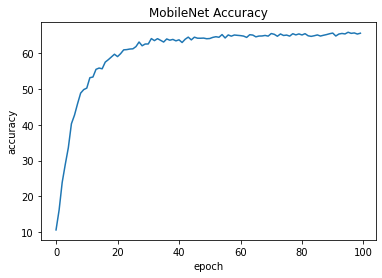

In [22]:
import matplotlib.pyplot as plt
plt.plot(mm_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('MobileNet Accuracy')
plt.show()

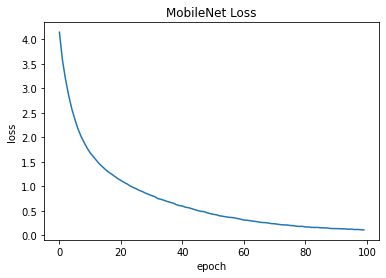

In [23]:
import matplotlib.pyplot as plt
plt.plot(mm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MobileNet Loss')
plt.show()

### Graph - Plot

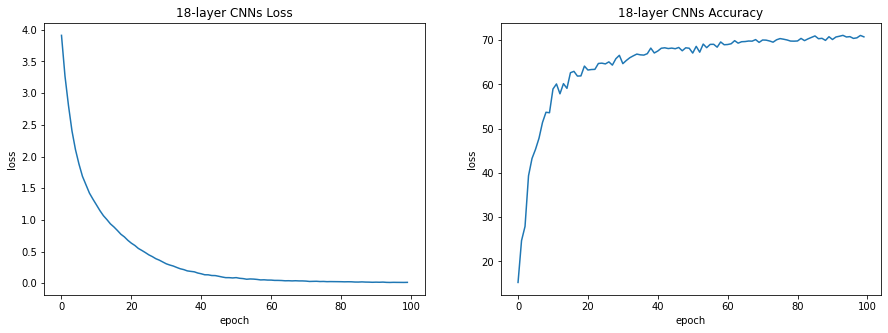

In [48]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(pm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('18-layer CNNs Loss')
plt.subplot(1, 2, 2)
plt.plot(pm_accuracy)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('18-layer CNNs Accuracy')
plt.show()

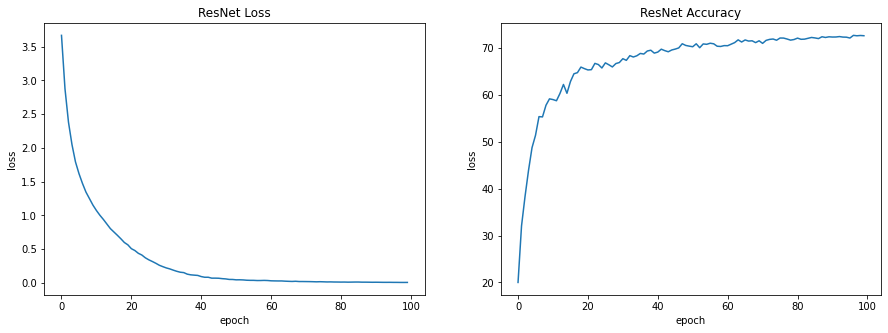

In [51]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(rm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ResNet Loss')
plt.subplot(1, 2, 2)
plt.plot(rm_accuracy)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('ResNet Accuracy')
plt.show()

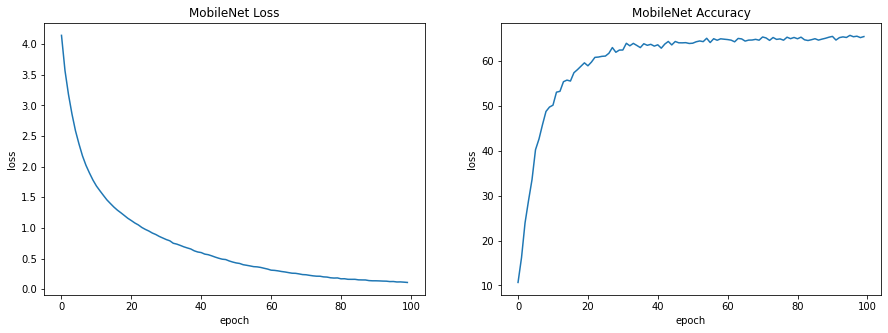

In [50]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(mm_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MobileNet Loss')
plt.subplot(1, 2, 2)
plt.plot(mm_accuracy)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MobileNet Accuracy')
plt.show()

# Construct the 18 layers network
**All of PlainNet18, ResNet18, MobileNet18 have same network structure but they are consist of different convolution block (PlainBlock, ResidualBlock, MobileBlock). You have to utilize Net18() when you define the network.**

In [27]:
class Net18(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(Net18, self).__init__()
        self.inp = 64
        self.conv0 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, oup, num_block, stride=1):
        layers = []
        strides = [stride] + [1]*(num_block-1)
        for stride in strides:
            layers.append(block(self.inp, oup, stride))
            self.inp = oup
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.relu(self.bn0(self.conv0(x)))
        out = self.layer1(out)
        out = self.layer2(out) 
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Task1 : Implement 18-layer CNNs for CIFAR100

In [28]:
class PlainBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(PlainBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=oup)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(oup, oup, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=oup)
        
        
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        return out

# Task2 : Implement ResNet18 for CIFAR100

In [8]:
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, inp, oup, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.conv1 = nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False) 
        self.bn1 = nn.BatchNorm2d(oup)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(oup, oup, kernel_size=3, stride=1, padding=1, bias=False) 
        self.bn2 = nn.BatchNorm2d(oup)

        self.shortcut = nn.Sequential()
        if self.stride != 1 or inp != self.expansion * oup:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inp, self.expansion*oup, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion*oup)
            )

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
  
        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)

        out = self.relu(out)
  
        return out

# Task3 : Implement MobileNet for CIFAR100

In [9]:
class MobileBlock(nn.Module):
    def __init__(self, inp, oup, stride=1):
        super(MobileBlock, self).__init__()
        
        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, groups=inp),
                nn.BatchNorm2d(oup),
                nn.ReLU(True),

                # pw
                nn.Conv2d(oup, oup, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(oup),
                nn.ReLU(True),
                )
        
        self.model = conv_dw(inp, oup, stride=stride)

    def forward(self, x):
        out = self.model(x)
        
        return out

### Model Complexity

In [36]:
# FLOPS

with torch.cuda.device(0):
    net = plainnet_model
    macs, params = get_model_complexity_info(net, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Net18(
  11.046 M, 100.000% Params, 0.551 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.016% Params, 0.002 GMac, 0.321% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.012% MACs, inplace=True)
  (layer1): Sequential(
    0.148 M, 1.340% Params, 0.152 GMac, 27.554% MACs, 
    (0): PlainBlock(
      0.074 M, 0.670% Params, 0.076 GMac, 13.777% MACs, 
      (conv1): Conv2d(0.037 M, 0.334% Params, 0.038 GMac, 6.853% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(0.0 M, 0.001% Params, 0.0 GMac, 0.024% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.024% MACs, inplace=True)
      (conv2): Conv2d(0.037 M, 0.334% Params, 0.038 GMac, 6.853% MACs, 64, 6

In [37]:
# FLOPS

with torch.cuda.device(0):
    net = mobilenet_model
    macs, params = get_model_complexity_info(net, (3, 32, 32), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Net18(
  0.778 M, 100.000% Params, 0.04 GMac, 100.000% MACs, 
  (conv0): Conv2d(0.002 M, 0.222% Params, 0.002 GMac, 4.452% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn0): BatchNorm2d(0.0 M, 0.016% Params, 0.0 GMac, 0.330% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.165% MACs, inplace=True)
  (layer1): Sequential(
    0.01 M, 1.299% Params, 0.011 GMac, 26.709% MACs, 
    (0): MobileBlock(
      0.005 M, 0.650% Params, 0.005 GMac, 13.355% MACs, 
      (model): Sequential(
        0.005 M, 0.650% Params, 0.005 GMac, 13.355% MACs, 
        (0): Conv2d(0.001 M, 0.082% Params, 0.001 GMac, 1.649% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (1): BatchNorm2d(0.0 M, 0.016% Params, 0.0 GMac, 0.330% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(0.0 M, 0.000% Params, 0.0 GMac, 0.165% MACs, inplace=Tr